# Capítulo 9 - Acessando bancos de dados Entrez do NCBI

Entrez (https://www.ncbi.nlm.nih.gov/Web/Search/entrezfs.html) é um sistema de recuperação de dados que fornece aos usuários acesso aos bancos de dados do NCBI, tais como PubMed, GenBank, GEO e muitos outros. Você pode acessar o Entrez a partir da internet de modo manual ou usar o módulo `Bio.Entrez` do Biopython. Usando o Entrez como script, você pode, por exemplo, fazer pesquisas no PubMed ou baixar registros do GenBank.

O módulo `Bio.Entrez` faz uso do *Entrez Programming Utilities* (também conhecido como EUtils), consitindo em oito ferramentas que são descritas em detalhes na página do NCBI: https://www.ncbi.nlm.nih.gov/books/NBK25501/. Cada uma dessas ferramentas corresponde a uma função do módulo `Bio.Entrez` no Python, como descrito nas seções desse capítulo. Esse módulo grante que a URL correta seja usada nas pesquisas, e que as diretrizes responsáveis pelo acesso aos dados do NCBI sejam seguidas.

A saída retornada pelo EUtils geralamente é em um arquivo XML. Para analisar tal saída, você tem algumas opções:

1. Usar o analisador do `Bio.Entrez` para analisar a saída XML em um objeto Python;

2. Usar um dos analisadores XML disponível na biblioteca padrão do Python ou;

3. Ler a saída XML como texto bruto e analisá-lo por pesquisa e manipulação de string.

Veja a documentação do Python para os analisadores de XML em suas bibliotecas nativas (https://docs.python.org/pt-br/3.10/library/xml.html). Discutiremos aqui o analisador presente no Biopython com o módulo `Bio.Entrez`. Esse analisador pode ser usado para analisar os dados fornecidos por do Entrez por meio da programação, mas pode ser usado também para analisar dados em XML do NCBI Entrez que estão armazenados em um arquivo. Nesse último caso, o arquivo XML dele ser aberto em modo binário (e.g. **open('meu_arquivo.xml', 'rb')**) para que o analisador do XML no `Bio.Entrez` trabalhe corretamente.

O NCBI usa arquivos DTD (em inglês, *Document Type Definition*) para descrever a estrutura da informação contida em arquivos XML. Muitos dos arquivos DTD usados pelo NCBI estão incluídos no Biopython. O analisador `Bio.Entrez` faz uso dos arquivos DTD quando analisa um arquivo XML retornado pelo NCBI Entrez.

Ocasionalmente, você pode descobrir que o arquivo DTD associado com um arquivo XML específico está faltando no Biopython. Em particlar, isso acontece quando o NCBI atualiza os arquivos DTD. Se isso acontecer, **Entrez.read** mostrará uma mensagem de aviso com o nome e a URL do arquivo DTD faltante. O analisador procederá para o acesso do arquivo DTD faltante via internet, permitindo a análise do arquivo XML. Porém, o analisador é muito mais rápido se o arquivo DTD estiver disponível localmente. Para isso, baixe o arquivo DTD da URL mostrada na mensagem de aviso e coloque no diretório **...site-packages/Bio/Entrez/DTDs**, onde contém os outros arquivos DTD. Se você não tiver acesso a esse diretório, você pode colocar o arquivo DTD no diretório **~/.biopython/Bio/Entrez/DTDs**, onde o **~** representa o seu diretório principal. Uma vez que esse diretório é lido antes do primeiro, você também pode colocar versões recentes dos arquivos DTD se os presentes no primeiro diretório estiverem desatualizados. De modo alternativo, se você instalou o Biopython da fonte, pode adicionar o arquivo DTD ao diretório **Bio/Entrez/DTDs** do código fonte e reinstalar o Biopython. Isso instalará o novo arquivo DTD no local correto junto com os outros arquivos DTD.

O EUtils também pode gerar saídas em outros formatos, tais como arquivos FASTA ou GenBank para banco de dados de sequência, ou formato MedLine para o banco de dados de literatura; discutido na **Seção 9.13**.

As funções presentes no `Bio.Entrez` para acesso via programação ao Entrez também retorna os dados em formato binário ou em texto, dependendo do tipo de requisição do dado. Em muitos casos, essas funções retornam o dado em formato de texto, decodificando o dado obtido de NCBI Entrez para strings Python, assumindo que a codificação seja a UTF-8. Todavia, dados em XML são retornados no formato binário. A razão para isso é que a codificação é especificada no próprio documento XML, o que indica que você não saberá o tipo correto de codificação até que comece a análise do arquivo. Portanto, o analisador do `Bio.Entrez` aceita os dados em formato binário, extrai a codificação do XML e usa isso pra decodificar todo o texto presente no documento XML para strings Python, garantindo que todo o texto (em particular, idiomas além do Inglês) seja interpretado corretamente. Essa também é a razão do porque você deve abrir um arquivo XML no modo binário quando você quiser usar o analisador do `Bio.Entrez`.

## 9.1 Diretrizes do Entrez

Antes de usarmos o Biopython para acessar os recursos online do NCBI, vamos ver o que temos no Requisitos do usuário Entrez do NCBI (https://www.ncbi.nlm.nih.gov/books/NBK25497/). Se o NCBI achar que você está abusando dos seus sistemas, ele poderá e banirá o seu acesso!

Parafraseando:

- Para qualquer série com mais de 100 requisiões, faça isso nos finais de semana ou fora dos horários de pico dos EUA. Depende de você obedecer;

- Use o endereço web https://eutils.ncbi.nlm.nih.gov (cai na página do livro sobre o Entrez), não o endereço online do NCBI. O Biopython usa esse endereço web;

- Se você estiver usando uma chave API, você pode fazer até 10 consultas por segundo, caso contrário são no máximo 3 consultas por segundo. Isso é aplicado automaticamente pelo Biopython. Inclua o argumento **api_key='MinhaChaveAPI'** ou configure como uma variável do módulo:

In [ ]:
from Bio import Entrez
# Não rodar essa célula, pois altera a API e os exemplos não funcionam
Entrez.api_key = 'MinhaChaveAPI'

- Use o parâmetro opcional de email para que o NCBI entre em contato com você caso surja algum problema. Você também pode definir explicitamente como um parâmetro com cada chamada para Entrez, ou você pode configurar um email global:

In [ ]:
from Bio import Entrez
# Não rodar essa célula, pois altera a API e os exemplos não funcionam
Entrez.email = 'teste@example.com'

- `Bio.Entrez` então usará esse endereço de email com cada chamada do Entrez. O domímio **example.com** é um domínio de endereço reservado especialmente para documentação (RFC 2606). Por favor, **NÃO USE** um email aleatório, é melhor não informar um email nesse caso. Em caso de uso excessivo, o NCBI tentará contatar o usuário do email fornecido antes de bloquear o acesso às utilidades do Enrtez;

- Se você estiver usando o Biopython dentro de um pacote de software mario, use o parâmetro da ferramenta para especificar isso. Você pode definir explicitamente o nome da ferramenta como um parâmetro com cada chamada do Entrez, ou configurar o nome da ferramenta de modo global:

In [ ]:
from Bio import Entrez
# Não rodar essa célula, pois altera a API e os exemplos não funcionam
Entrez.tool = 'MeuScriptLocal'

- O parâmetro da ferramenta será o padrão Biopython e;

- Para grandes consultas o NCBI também recomenda o uso de seu recurso de histórico de seção (a string do cookie da seção WebEnv, veja a **Seção 9.16**). Isso é apenas um pouco mais complicado, mas não impossível.

Para concluir, seja sensato com seus níveis de uso. Se você pretende baixar muitos dados, considere outras opções. Por exemplo, se você quer acessar facilmente os genes humanos, considere buscar cada cromossomo pelo FTP como um arquivo GenBank e importe os importe para o seu banco de dados BioSQL (veja a **Seção 20.5** no Capítulo 20: ***link do capítulo 20***).

## 9.2 EInfo: Obtendo informações sobre os bancos de dados Entrez

EInfo fornece contagem de termos de índice, última atualização e links disponíveis para cada banco de dados do NCBI. Além disso, você pode usar o EInfo para obter uma lista com todos os nomes do banco de dados acessíveis através do Entrez utilities:

In [1]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.einfo()
resultado = identificador.read()
identificador.close()

A variável **resultado** contém agora uma lista dos bancos de dados em formato XML:

In [2]:
print(resultado)

b'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE eInfoResult PUBLIC "-//NLM//DTD einfo 20190110//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20190110/einfo.dtd">\n<eInfoResult>\n<DbList>\n\n\t<DbName>pubmed</DbName>\n\t<DbName>protein</DbName>\n\t<DbName>nuccore</DbName>\n\t<DbName>ipg</DbName>\n\t<DbName>nucleotide</DbName>\n\t<DbName>structure</DbName>\n\t<DbName>genome</DbName>\n\t<DbName>annotinfo</DbName>\n\t<DbName>assembly</DbName>\n\t<DbName>bioproject</DbName>\n\t<DbName>biosample</DbName>\n\t<DbName>blastdbinfo</DbName>\n\t<DbName>books</DbName>\n\t<DbName>cdd</DbName>\n\t<DbName>clinvar</DbName>\n\t<DbName>gap</DbName>\n\t<DbName>gapplus</DbName>\n\t<DbName>grasp</DbName>\n\t<DbName>dbvar</DbName>\n\t<DbName>gene</DbName>\n\t<DbName>gds</DbName>\n\t<DbName>geoprofiles</DbName>\n\t<DbName>homologene</DbName>\n\t<DbName>medgen</DbName>\n\t<DbName>mesh</DbName>\n\t<DbName>ncbisearch</DbName>\n\t<DbName>nlmcatalog</DbName>\n\t<DbName>omim</DbName>\n\t<DbName>orgtrack</Db

Uma vez que esse arquivo XML é bastante simples, podemos extrair as informações usando uma busca por strings. Usando o analisador do `Bio.Entrez`, podemos analisar diretamente o arquivo XML como um objeto Python:

In [3]:
from Bio import Entrez
identificador = Entrez.einfo()
registro = Entrez.read(identificador)

Agora **registro** é um dicionário com exatamente uma chave:

In [4]:
registro.keys()

dict_keys(['DbList'])

Os valores armazenados nessa chave é uma lista dos nomes dos bancos de dados mostrados no XML acima:

In [5]:
registro['DbList']

['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'ncbisearch', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'biosystems', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']

Para cada um desses banco de dados, podemos usar o EInfo novamente para obter mais informações:

In [6]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.einfo(db='pubmed')
registro = Entrez.read(identificador)
registro['DbInfo']['Description']

'PubMed bibliographic record'

In [7]:
registro['DbInfo']['Count']

'33385939'

In [8]:
registro['DbInfo']['LastUpdate']

'2021/11/30 14:37'

Tente usar **registro['DbInfo'].keys()** para acessar as outras informações presentes nesse registro:

In [9]:
registro['DbInfo'].keys()

dict_keys(['DbName', 'MenuName', 'Description', 'DbBuild', 'Count', 'LastUpdate', 'FieldList', 'LinkList'])

Um dos mais úteis é uma lista de possíveis pesquisas para usar como o ESearch:

In [10]:
for campo in registro['DbInfo']['FieldList']:
    print('%(Name)s, %(FullName)s, %(Description)s'%campo)

ALL, All Fields, All terms from all searchable fields
UID, UID, Unique number assigned to publication
FILT, Filter, Limits the records
TITL, Title, Words in title of publication
WORD, Text Word, Free text associated with publication
MESH, MeSH Terms, Medical Subject Headings assigned to publication
MAJR, MeSH Major Topic, MeSH terms of major importance to publication
AUTH, Author, Author(s) of publication
JOUR, Journal, Journal abbreviation of publication
AFFL, Affiliation, Author's institutional affiliation and address
ECNO, EC/RN Number, EC number for enzyme or CAS registry number
SUBS, Supplementary Concept, CAS chemical name or MEDLINE Substance Name
PDAT, Date - Publication, Date of publication
EDAT, Date - Entrez, Date publication first accessible through Entrez
VOL, Volume, Volume number of publication
PAGE, Pagination, Page number(s) of publication
PTYP, Publication Type, Type of publication (e.g., review)
LANG, Language, Language of publication
ISS, Issue, Issue number of publ

Essa é uma longa lista, mas indiretamente isso diz a você que para o banco de dados do PubMed, você pode fazer coisas como **Jones[AUTH]** para pesquisar o autor, ou **Sanger[AFFL]** para restringir os autores ao Wellcome Sanger Institute. Isso pode ser muito útil, especialmente e você não estiver familiarizado com um banco de dados em particular.

## 9.3 ESearch: Pesquisando os bancos de dados de Entrez

Para pesquisar em qualquer banco de dados, usaremos o `Bio.Entrez.esearch()`. Por exemplo, vamos procurar no PubMed publicações que incluem o Biopython em seu título:

In [11]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.esearch(db='pubmed', term='biopython[title]', retmax='40')
registro = Entrez.read(identificador)
'19304878' in registro['IdList']

True

In [12]:
print(registro['IdList'])

['34434786', '22909249', '19304878']


Nessa saída, vemos os IDs do PubMed (se tiver curiodidade, procure esses IDs no PubMed para ver do que se trata), que pode ser revuperado pelo EFetch (veja a **Seção 9.6**).

Você também pode usar o ESearch para fazer pesquisas no GenBank. Faremos uma rápida pesquisa no gene *matK* das orquídeas *Cypripedioideae* (veja a **Seção 9.2** sobre o EInfo para descobrir quais campos você pode pesquisar em cada banco de dados Entrez):

In [13]:
from Bio import Entrez
identificador = Entrez.esearch(db='nucleotide', term='Cypripedioideae[Orgn] AND matK[Gene]', idtype='acc')
registro = Entrez.read(identificador)
registro['Count']

'585'

In [14]:
registro['IdList']

['NC_058834.1', 'NC_058833.1', 'NC_058832.1', 'OK120861.1', 'OK120860.1', 'NC_058212.1', 'NC_058211.1', 'NC_058210.1', 'NC_058209.1', 'NC_058208.1', 'NC_058207.1', 'NC_058206.1', 'MN315109.1', 'MN315108.1', 'MN315107.1', 'MN315106.1', 'MN315105.1', 'NC_056912.1', 'MZ150831.1', 'MZ150830.1']

Cada um dos IDs (NC_058834.1, NC_058833.1, NC_058832.1) é um identificador do GenBank (Número de acesso). Veja a **Seção 9.6** para mais informações de como baixar os registros do GenBank.

Observe que ao invés de um nome de espécie como **Cypripedioideae[Orgn]**, você pode restringir a pesquisa usando um identificador taxonômico do NCBI, que no caso poderia ser **txid158330[Orgn]**. Esse modo de pesquisa não estão devidamente documentado na página web de ajuda de ESearch. Muitas vezes, você pode deduzir a formatação do termo de pesquisa brincando com a interface da web do Entrez. Por exemplo, incluir o termo **complete[prop]** na pesquisa de genoma restringe a pesquisa apenas para genomas completos.

Como exemplo final, vamos obter uma lista de títulos de periódicos computacionais:

In [15]:
from Bio import Entrez
identificador = Entrez.esearch(db='nlmcatalog', term='computational[Journal]', retmax='20')
registro = Entrez.read(identificador)
num_counts = registro['Count']
print(f'Foram encontrados {num_counts} periódicos computacionais.')

Foram encontrados 187 periódicos computacionais.


In [16]:
primeiros_periodicos = registro['IdList']
print(f'Os primeiros 20 periódicos são:\n{primeiros_periodicos}')

Os primeiros 20 periódicos são:
['101775476', '101775136', '468912', '468839', '467370', '101775780', '101774751', '466063', '101768752', '101765300', '101759185', '101752828', '464655', '101768811', '101755127', '101753951', '101753371', '101740904', '101737789', '101736625']


Novamente, você pode usar o EFetch para obter mais informações de cada um desses periódicos.

ESearch possi muitas opções úteis, veja a página wweb para mais informações: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch.

## 9.4 Epost: Enviando uma lista de identificadores

EPost envia uma lista de UIs para uso em estratégias de pesquisa subsequentes; veja a página de ajuda online do EPost para mais informações (https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EPost). Essa ferramenta está disponível no Biopython pelo módulo `Bio.Entrez.epost()`.

Para dar um exemplo de quão essa função é útil, suponha que você tenha uma longa lista de IDs e quer baixá-las usando o EFetch (talvez as sequências, ou citações, ou qualquer informação). Quando você faz uma requisição com o EFetch com a sua lista de IDs, banco de dados, etc, tudo é transformado em uma longa URL que pe mandada para o servidor. Se a sua lista de IDs é longa, essa URL será longa e URLs longas podem quebrar.

Ao invés disso, você pode separar em duas etapas; primeiro enviando a lista de IDs usando o EPost (isso usa um 'HTML post' internamente, ao invés de um 'HTML get', contornando assim o problema da URL longa).
Com o suporte de histórico, você pode consultar uma longa lista de IDs e baixar os dados associados com o EFetch.

Vejamos um exemplo simples para entender como o EPost funciona, enviando alguns identificadores PubMed:

In [17]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
lista_ids = ['19304878', '18606172', '16403221', '16377612', '14871861', '14630660']
print(Entrez.epost('pubmed', id=','.join(lista_ids)).read())

b'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE ePostResult PUBLIC "-//NLM//DTD epost 20090526//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20090526/epost.dtd"><ePostResult>\n\t<QueryKey>1</QueryKey>\n\t<WebEnv>MCID_61a7d13c31a0a8799a1add54</WebEnv>\n</ePostResult>\n'


O XML retornado inclui duas strings importantes: **QueryKey** e **WebEnv** que juntas definem o nosso histórico da seção. Você pode extrair esses valores para usar em outra chamada do Entrez, como no EFetch:

In [18]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
lista_ids = ['19304878', '18606172', '16403221', '16377612', '14871861', '14630660']
resultados_pesquisa = Entrez.read(Entrez.epost('pubmed', id=','.join(lista_ids)))
webenv = resultados_pesquisa['WebEnv']
query_key = resultados_pesquisa['QueryKey']

In [19]:
webenv

'MCID_61a7d13de2ebbf4b9114316b'

In [20]:
query_key

'1'

Veja a **Seção 9.16** para saber como usar o recurso de histórico.

## 9.5 ESummary: Recuperando resumos de IDs primários

ESummary recupera resumos de documentos de uma lista de IDs primários (veja a página web de ajuda do ESummary para mais informações: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESummary). No Biopython, o ESummary está disponível pelo módulo `Bio.Entrez.esummary()`. Usando o resultado de pesquisa acima, podemos, por exemplo, descobrir mais sobre o periódico de ID 101660833:

In [21]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.esummary(db='nlmcatalog', id='101660833')
registro = Entrez.read(identificador)
info = registro[0]['TitleMainList'][0]
id_periodico = registro[0]['Id']
titulo_periodico = info['Title']
print(f'''Informação do periódico
ID: {id_periodico}
Título: {titulo_periodico}''')

Informação do periódico
ID: 101660833
Título: IEEE transactions on computational imaging.


## 9.6 EFetch: Baixando registros completos do Entrez

EFetch é usando quando você quer recuperar um registro completo do Entrez. Isso cobre várioas bancos de dados possíveis, como descrito na página online de ajuda do EFetch: https://www.ncbi.nlm.nih.gov/books/NBK3837/.

Para a maioria dos seus bancos de dados, o NCBI suporta vários tipos de arquivos. Requisitar um formato específico de arquivo do Entrez usando o `Bio.Entrez.efetch()`, requer que os argumentos opcionais **rettype** e/ou **retmode** sejam especificados. As diferentes combinações são descritas para cada tipo de banco de dados nas páginas lincadas à página do EFetch no NCBI: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EFetch.

Um uso comum é baixar sequências no formato FASTA ou GenBank/GenPept como textos, que podem ser analisados com o `Bio.SeqIO` (veja a **Seção 5.3.1** para mais informações no Capítulo 5: https://github.com/GTL98/biopython_br/tree/main/Cap%205%20-%20Sequ%C3%AAncias%20Input_Output). Usaremos os mesmo dados dos exemplos acima. Podemos baixar o registro EU490707 do GenBank usando o `Bio.Entrez.efetch()`:

In [22]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.efetch(db='nucleotide', id='EU490707', rettype='gb', retmode='text')
print(identificador.read())

LOCUS       EU490707                1302 bp    DNA     linear   PLN 26-JUL-2016
DEFINITION  Selenipedium aequinoctiale maturase K (matK) gene, partial cds;
            chloroplast.
ACCESSION   EU490707
VERSION     EU490707.1
KEYWORDS    .
SOURCE      chloroplast Selenipedium aequinoctiale
  ORGANISM  Selenipedium aequinoctiale
            Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta;
            Spermatophyta; Magnoliopsida; Liliopsida; Asparagales; Orchidaceae;
            Cypripedioideae; Selenipedium.
REFERENCE   1  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A., Endara,L.,
            Williams,N.H. and Moore,M.
  TITLE     Phylogenetic utility of ycf1 in orchids: a plastid gene more
            variable than matK
  JOURNAL   Plant Syst. Evol. 277 (1-2), 75-84 (2009)
REFERENCE   2  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A.,
            Endara,C.L., Williams,N.H. and Moore,M.J.
  TIT

Vale ressaltar que a partir de Outubro de 2016 os identificadores GI foram descontinados em favor dos números de acesso. Caso você queira baixar manualmente o arquivo, basta selecionar a opção 'show GI', como mostrado na figura abaixo:

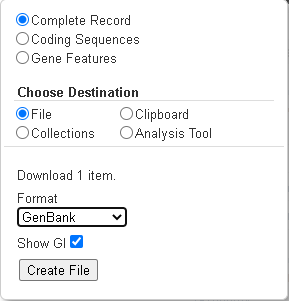

Você pode continuar buscando sequências baseadas no GI, mas as novas sequências não possuem mais esse identificador. Ao invés disso, você deve informar o 'Accession number' como feito no exemplo.

Os argumento **rettype='gb'** e **retmode='text'** permite que baixemos esse registro no formato GenBank.

Note que até o Outono de 2009, a API do Entrez EFetch permitia que você usasse 'genbank' como o tipo retornado, porém, o NCBI insiste que você use o tipo de retorno oficial como 'gb' ou 'gbwithparts' (ou 'gp' para proteínas) como descrito online. Observe também que até Fevereiro de 2012, a API do Entrez EFetch retornava como padrão um texto, agora o padrão é XML.

De modo alternativo, você pode, por exemplo, usar o argumento **rettype='fasta'** para obter a saída em formato FASTA. Lembre-se que os formatos disponíveis dependem de qual banco de dados você está fazendo o download.

Se você buscar o registro em um dor formatos aceitos pelo `Bio.SeqIO` (veja o Capítulo 5: https://github.com/GTL98/biopython_br/tree/main/Cap%205%20-%20Sequ%C3%AAncias%20Input_Output), você pode analisar diretamente em um objeto **SeqRecord**:

In [23]:
from Bio import SeqIO
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.efetch(db='nucleotide', id='EU490707', rettype='gb', retmode='text')
registro = SeqIO.read(identificador, 'gb')
identificador.close()
print(registro.id)

EU490707.1


In [24]:
print(registro.name)

EU490707


In [25]:
print(registro.description)

Selenipedium aequinoctiale maturase K (matK) gene, partial cds; chloroplast


In [26]:
print(len(registro.features))

3


In [27]:
registro.seq

Seq('ATTTTTTACGAACCTGTGGAAATTTTTGGTTATGACAATAAATCTAGTTTAGTA...GAA')

Observe que a maneira mais comum seria salvar os dados da sequência em um arquivo local e aí sim analisá-lo com o `Bio.SeqIO`. Isso pode evitar que você baixe novamente o mesmo arquivo repetidas vezes enqunto trabalha em seu código e coloca menos carga nos servidores do NCBI. Por exemplo:

In [28]:
import os
from Bio import SeqIO
from Bio import Entrez
Entrez.email = 'teste@example.com'
nome_arquivo = 'EU490707.gbk'
if not os.path.isfile(nome_arquivo):
    # Baixando...
    identificador_net = Entrez.efetch(
    db='nucleotide', id='EU490707', rettype='gb', retmode='text'
    )
    identificador_saida = open(nome_arquivo, 'w')
    identificador_saida.write(identificador_net.read())
    identificador_saida.close()
    identificador_net.close()
    print('Salvo!')
print('Analisando...')
registro = SeqIO.read(nome_arquivo, 'gb')
print(registro)

Analisando...
ID: EU490707.1
Name: EU490707
Description: Selenipedium aequinoctiale maturase K (matK) gene, partial cds; chloroplast
Number of features: 3
/molecule_type=DNA
/topology=linear
/data_file_division=PLN
/date=26-JUL-2016
/accessions=['EU490707']
/sequence_version=1
/keywords=['']
/source=chloroplast Selenipedium aequinoctiale
/organism=Selenipedium aequinoctiale
/taxonomy=['Eukaryota', 'Viridiplantae', 'Streptophyta', 'Embryophyta', 'Tracheophyta', 'Spermatophyta', 'Magnoliopsida', 'Liliopsida', 'Asparagales', 'Orchidaceae', 'Cypripedioideae', 'Selenipedium']
/references=[Reference(title='Phylogenetic utility of ycf1 in orchids: a plastid gene more variable than matK', ...), Reference(title='Direct Submission', ...)]
Seq('ATTTTTTACGAACCTGTGGAAATTTTTGGTTATGACAATAAATCTAGTTTAGTA...GAA')


Para obter o formato XML, que você pode usar o `Bio.Entrez.read()` para analisar, use **retmode='xml'**:

In [29]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.efetch(db='nucleotide', id='EU490707', retmode='xml')
registro = Entrez.read(identificador)
identificador.close()
registro[0]['GBSeq_definition']

'Selenipedium aequinoctiale maturase K (matK) gene, partial cds; chloroplast'

In [30]:
registro[0]['GBSeq_source']

'chloroplast Selenipedium aequinoctiale'

Então, isso tratava de sequências. Por exemplo, para análises de formatos específicos de outros banco de dados (e.g. o formato **MEDLINE** usado no PubMed), veja a **Seção 9.13**.

Se você deseja realizar uma pesquisa com o `Bio.Entrez.esearch()` e baixar os registros com o `Bio.Entrez.efetch()`, você deveria usar a recuso de histótico do WebEnv (veja a **Seção 9.16**).

## 9.7 ELink: Procurando por itens relacionados no NCBI Entrez

ELink, disponível no Biopython pelo módulo `Bio.Entrez.elink()`, pode ser usado para encontrar itens relacionados nos banco de dados NCBI Entrez. Por exemplo, você pode usá-lo para encontrar entradas de nucleotídeos para uma entrada no banco de dados de genes, e outras coisas legais.

Vamos usar o ELink para encontrar artigos relacionados ao Biopython em *Bioinformatics* em 2009. O ID do PubMed do artigo é 19304878:

In [31]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
pmid = '19304878'
registro = Entrez.read(Entrez.elink(dbfrom='pubmed', id=pmid))

a variável **registro** consiste de uma lista Python, uma para cada base de dados que pesquisamos. Uma vez que especificamos apenas o ID do PubMed para pesquisa, **registro** contém somente um item. Esse item é um dicionário contendo as informações sobre o nosso termo de pesquisa, bem como todos os itens relacionados que foram encontrados:

In [32]:
registro[0]['DbFrom']

'pubmed'

In [33]:
registro[0]['IdList']

['19304878']

A chave **'LinkSetDb'** contém os resultados da pesquisa armazenados como uma lista, consistindo de um item para cada alvo do banco de dados. Em nossos resultados de pesquisa, encontramos apenas hits no banco de dados do PubMed (embora subdividido em categorias):

In [34]:
len(registro[0]['LinkSetDb'])

8

Os números exatos devem aumentar com o tempo:

In [35]:
print('Hoje: 01/12/2021 as 14:57')
print('\n')
for link_set_db in registro[0]['LinkSetDb']:
    print(link_set_db['DbTo'], link_set_db['LinkName'], len(link_set_db['Link']))

Hoje: 01/12/2021 as 14:57


pubmed pubmed_pubmed 168
pubmed pubmed_pubmed_alsoviewed 21
pubmed pubmed_pubmed_citedin 1332
pubmed pubmed_pubmed_combined 6
pubmed pubmed_pubmed_five 6
pubmed pubmed_pubmed_refs 17
pubmed pubmed_pubmed_reviews 15
pubmed pubmed_pubmed_reviews_five 8


Os atuais resultados de pesquisa estão armazenados na chave **'Link'**. Vamos ver o primeiro resultado de pesquisa:

In [36]:
registro[0]['LinkSetDb'][0]['Link'][0]

{'Id': '19304878'}

Esse artigo que procuramos, o que não nos ajuda muito. Então vamos dar uma olhada no segundo resultado de pesquisa:

In [37]:
registro[0]['LinkSetDb'][0]['Link'][1]

{'Id': '14630660'}

Esse artigo, com o ID do PubMed de 14630660, é sobre o analisador Biopython PDB. Podemos usar um loop para mostrar todos os IDs da pesquisa no banco de dados do PubMed:

In [38]:
for link in registro[0]['LinkSetDb'][0]['Link']:
    print(link['Id'])

19304878
14630660
22909249
20739307
31278684
23023984
25273102
18689808
23842806
20847218
18251993
20733063
19628504
15572471
22399473
31310539
20823319
12368254
29253085
20421198
30285630
24064416
25236461
22332238
32637988
16377612
18238804
14512356
22581176
22302572
12230038
25661541
15096277
21216774
15723693
32044951
23633579
18593718
15130828
17237069
21352538
28407033
24463182
33341884
29641230
20973958
19181685
17441614
28302053
26030926
23456039
29048466
32960970
22815363
18227118
22368248
17101041
20591906
17384428
16539535
20334363
22824207
18252737
17316423
20375454
14751976
16257987
23479348
31650686
14871861
32407511
25677125
15969769
25414366
32935829
27493193
21949271
22500002
17237072
26446134
24885957
27153673
24503186
29236954
22276101
17537750
26394715
15059834
19773334
30735498
30235322
19106120
19460889
22877863
26079347
29558112
15980554
28333216
20537149
19698094
23292976
21385461
21210978
24564380
22556367
21798964
22396485
20015970
21210984
22595207
33594436
2

Isso foi muito legal, mas se você estiver interessado em saber as citações do, o ELink consegue fazer isso. Veja a **Seção 9.16.3** para mais detalhes.

Em caso de dúvidas, visite a página web de ajuda do ELink: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ELink. Há uma subpágina inteira apenas para os nomes dos link (https://eutils.ncbi.nlm.nih.gov/corehtml/query/static/entrezlinks.html), descrevendo como diferentes bancos de dados podem ter referências cruzadas.

## 9.8 EGQuery: Consulta Global - conta para termos de pesquisa

EGQuery fornece conta para um termo de pesquisa em cada base de dados Entrez (i.e. uma consulta global). Isso é particularmente útil para descobrir quantos itens seus termos de pesquisa encontrarão em cada banco de dados sem realmente realizar muitas pesquisas separadas com o ESearch (veja o exemplo da **Seção 9.15.2**).

Nesse exemplo, usaremos o módulo `Bio.Entrez.egquery()` para obter a contagem de 'Biopython':

In [39]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.egquery(term='biopython')
registro = Entrez.read(identificador)
for linha in registro['eGQueryResult']:
    print(linha['DbName'], linha['Count'])

pubmed 36
pmc 2152
mesh 0
books 2
pubmedhealth Error
omim 0
ncbisearch 1
nuccore 2
nucgss 0
nucest 0
protein 0
genome 0
structure 0
taxonomy 0
snp 0
dbvar 0
gene 0
sra 1
biosystems 0
unigene 0
cdd 0
clone 0
popset 0
geoprofiles 0
gds 17
homologene 0
pccompound 0
pcsubstance 0
pcassay 0
nlmcatalog 0
probe 0
gap 0
proteinclusters 0
bioproject 1
biosample 0
biocollections 0


Veja a página web de ajuda em caso de dúvidas: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EGQuery

## 9.9 ESpell: Obtenção de sugestões de ortografia

ESpell recupera sugestões de ortografia. Nesse exemplo, usaremos o `Bio.Entrez.espell()` para obter a ortografia correta de 'Biopython':

In [40]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = Entrez.espell(term='biopythooon')
registro = Entrez.read(identificador)
registro['Query']

'biopythooon'

In [41]:
registro['CorrectedQuery']

'biopython'

Veja a página online de ajuda se precisar: https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESpell. O principal uso disso é para ferramentas com GUIs que fornecem automaticamente sugestões para os termos de pesquisa.

## 9.10 Analisando grandes arquivos Entrez XML

A fução **Entrez.read()** lê as entradas de arquivos XML retornado pelo Entrez em um único objeto Python, que é mantido na memória. Para analisar arquivos Entrez XML muito grandes para a memória, você pode usar a função **Entrez.parse()**. Essa é uma função geradora que lê os registros um por um em um arquivo XML. Essa função é apenas útil se o arquivo XML reflete um objeto de lista Python, em outras palavras, se **Entrez.read()** em um computador com recursos de memória infinita retornaria uma lista Python.

Por exemplo, você pode baixar todo o banco de dados Entrez Gene de um organismo em um arquivo do site ftp do NCBI. Esses arquivos são consideravelmente grandes. Como um exemplo, no dia 4 de Setembro de 2009, o arquivo **Homo_spiens.ags.gz** continha o banco de dados Entrez Gene do hmano, com um tamanho de 116576 kB. Esse arquivo, que está no formato **ANS**, pode ser convertido com o programa **gene2xml**:

- $ gene2xml -b T -i Homo_sapiens.ags -o Homo_sapiens.xml

O resultado é um arquixo XML de 6.1 GB! Usando o **Entrez.read()** pode gerar o erro **MemoryError** em muitos computadores.

O arquivo XML **Homo_sapiens.xml** consiste em uma lista de registro de genes Entrez, cada correspondência sendo um gene Entrez no humano. **Entrez.parse()** recupera esses registros de genes um por um. Você pode mostrá-los ou armazenar as informações relevantes de cada registro iterando sobre os registros. Por exemplo, o código abaixo itera sobre os registros de genes Entrez e mostra o número do gene e seu nome. Por motivos poder computacional, não executarei o código, mas deixarei ele montado como exemplo:

In [ ]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = open('Homo_sapiens.xml', 'b')
registros = Entrez.parse(identificador)
for registro in registros:
    status = registro['Entrezgene_track-info']['Gene-track']['Gene-track_status']
    if status.attributes['value'] == 'discontinued':
        continue
    id_gene = registro['Entrezgene_track-info']['Gene-track']['Gene-track_geneid']
    nome_gene = registro['Entrezgene_gene']['Gene-ref']['Gene-ref_locus']
    print(id_gene, nome_gene)

A saída é algo parecido com isso:

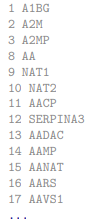

## 9.11 Caracteres de escape HTML

Resgitros PubMed podem conter tags HTML que indicam e.g. subscripts, superscripts ou texto em itálico, bem como símbolos matemáticos via MathML. Por padrão, o analisador `Bio.Entrez` trata todo o texto como texto plano sem marcações; por exemplo, o framento '*P* < 0.05' em um abstract de um registro PubMed é codificado como:

- < i >P< /i > &l t; 0.05

Em um XML retornado pelo Entrez, é convertido para uma string Python pelo analisador `Bio.Entrez`:

- '< i >P< /i > < 0.05'

Embora isso seja mais legível para um ser humano, não é um HTML válido devido ao sinal de menor (<) e faz o processamento posterior do texto e.g. por um analisador de HTML impraticável. Para garantir que todas as strings retornadas pelo analisador são um HTML válido, chame **Entrez.read()** ou **Entrez.parse()** com o argumento **escape** configurado como *True*:

- registro = Enrtez.read(identificador, escape=True)

O analisador recolocará todos os caracteres não permitidos em HTML por seu equivalente com escape de HTML; no exemplo acima, o analisador geraria um HTML válido. Por padrão, **escape** é *False*:

- '< i > P < /i > &l t; 0.05'

## 9.12 Manipulação de erros

Três coisas podem levar o analisador ao erro com um arquivo XML:

1. O arquivo pode não estar no formato XML;

2. O arquivo pode fechar prematuramente ou ser corrompido por outra forma e;

3. O arquivo pode se XML correto, mas contém itens que não são representados no DTD associado.

O primeiro caso ocorre quando, por exemplo, você tenta analisar um arquivo FASTA no lugar de um XML:

In [42]:
from Bio import Entrez
identificador = open('NC_005816.1.fna', 'rb')  # um arquivo FASTA
registro = Entrez.read(identificador)

NotXMLError: Failed to parse the XML data (syntax error: line 1, column 0). Please make sure that the input data are in XML format.

Aqui, o analisador não encontra a tag **<?xml...** com a qual um arquivo XML deve começar e, portanto, decide (corretamente) que o arquivo não está no formato XML.

Quando o seu arquivo é um XML mas está corrompido (e.g. fechado prematuramente), o analisador retornará o erro **CorruptedXMLError**. Aqui está um exemplo de um arquivo XML fechado prematuramente:

In [43]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = open('einfo_corrompido.xml', 'rb')
Entrez.read(identificador)

CorruptedXMLError: Failed to parse the XML data (no element found: line 16, column 0). Please make sure that the input data are not corrupted.

Note que a mensagem de erro te informa em qual ponto do arquivo XML o erro foi detectado.

O terceiro tipo de erro que pode acontecer é se o arquivo XML contiver tags que não têm uma descrição correspondente no arquivo DTD. Dentro deste arquivo, por alguma razão existe a tag **< DocsumList >** (e muitas outras) que não estão listadas no arquivo **eInfo_020511.dtd**, que é especificado na segunda linha como o DTD para este arquivo XML. Por padrão, o analisador parará e retornará o erro **ValidationError** se não conseguir encontrar alguma tag no DTD. Nesse exemplo temos um arquivo XML com essa característica:

In [44]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = open('einfo_incongruente.xml', 'rb')
registro = Entrez.read(identificador)

ValidationError: Failed to find tag 'DocsumList' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.

De modo opcional, você pode instruir ao analisador para pular tais tags ao invés de retornar o erro **ValidationError**. Isso pode ser feito chamando as funções **read** ou **parse** com o argumento **validate** configurado como *False*:

In [45]:
from Bio import Entrez
Entrez.email = 'teste@example.com'
identificador = open('einfo_incongruente.xml', 'rb')
registro = Entrez.read(identificador, validate=False)
identificador.close()

Obviamente, as informações contidas nas tags XML que não estão no DTD não estão presentes no registro retornado pelo **Entrez.read()**.

## 9.13 Analisadores especiais

**pag 166**